# Simulation Individu-centrée de la capture d'Insectes par la Méthode du Pot Barber


Intro à rédiger - Qu'est-ce qu'un pot Barber ? Pourquoi est-ce qu'il ne mesure pas réellement la densité ? Est-ce qu'on peut y remédier ? - Trouver une question de recherche à investiguer par cette simulation, i.e. des comportements, ou une hétérogénéité de l'habitat qui introduit de la complexité dans la simulation. 

[Pot Barber.jpg](attachment:2a922033-28fe-44c7-846f-bb7ba2b2064e.jpg)
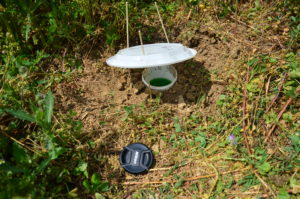

##### Import des bibliothèques utiles

In [1]:
from typing import Tuple

import numpy as np
from numpy import random

from matplotlib import animation, rc
import matplotlib.pyplot as plt
import itertools

NB : Pour faire tourner ce code, j'ai du installer ffmpeg-python (taper *conda install ffmpeg-python* dans la console Ananconda Anaconda-Prompt) et pygraphviz (taper *conda install pygraphviz* dans la console Ananconda Anaconda-Prompt)

In [2]:
rc('animation', html='html5')

### Partie 1. Définitions

#### Définition du champ

On se place dans un champs d'un hectare (100 m par 100 m) dans lequel se déplacent un certains nombres d'insectes au sol. Dans ce champs on a placé un/des Pot Barber pour capturer les insectes afin d'estimer leur densité.

<font color='blue'> Pour l'instant on considère que le champs est un milieu homogène, mais on pourra tout à fait introduire de l'hétérogénéité, comme des bandes enherbées, fleuries, des haies en bordure et à l'intérieur du champs des cultures en rangs, en rangs alternés, et même des patchs d'adventices distribués aléatoirement sur la parcelle </font>

<font color='blue'> *Là il faut afficher une image toute bête du champ, avec éventuellement un ou plusieurs pot Barber dedans*  </font>

#### Modalités de déplacement des insectes

On considère que le déplacement des insectes est isotrope (il est equiprobable dans toutes les directions) et que la distance qu'ils parcourent à chaque pas de temps est aléatoire (tirée dans une loi normale par exemple).

Le déplacement des insectes à chaque pas de temps sera défini par un vecteur dont la direction (celle que va prendre l'insecte) est aléatoire, et dont la norme (qui correspond à la distance que va parcourir l'insecte) est tirée dans une loi normale.

<font color='blue'> *Plus tard on pourra imaginer - (i) Ajouter plusieurs espèces avec des capacités de dispersion différentes / (ii) Ajouter des mouvements pas tout à fait random / (iii) Ajouter des mouvements qui dépendent de l'habitat.* </font>

<font color='green'> **Question Possible** : A partir de la fonction *random_unit_vector()* ci-dessous qui renvoie un vecteur unité dont la direction est aléatoire, construire une fonction *random_walk_vector()* dont la direction est aléatoire et la norme tirée dans une loi normale de moyenne mu et d'écart-type sigma, représentant les capacités de dispersion d'un individu. Indice : la fonction np.random.normal(mu, sigma) renvoie une valeure tirée dans une valeure tirée dans une loi normale de moyenne mu et d'écart-type sigma  </font>

<font color='green'> **Solution** </font>

In [3]:
mu = 2 ; sigma = 2

def random_walk_vector(mu, sigma) :
    
    """Gets a random vector (random direction, gaussian norm)"""
    
    norm = np.random.normal(mu, sigma)
    angle = random.random() * 2 * np.pi
    
    return norm*np.cos(angle), norm*np.sin(angle)

#### Définition du déplacement

Dans cette section, on simule le déplacement d'un insecte sur *num_steps = 100* pas de temps. Le déplacement de l'insecte est défini comme  la suite de ses localisations successives, stockées dans une matrice de taille *2 x num_steps*.

<font color='blue'> Ici on peut etayer la description du mouvement, en modifiant la gaussienne utilisée (en utilisant d'autres noyaux de dispersion plus sophistiqués par exemple) en rendant possible des épisodes de vol, ou en introduisant des mouvements orientés (partant du bord des parcelles par exemple, ou des stratégie d'évitement de ses congénères ou d'autres insectes), ou dépendant de l'habitat (+ lent dans des habitats favorables, et + rapide dans les habitats défavorables par exemple). On peut également modifier les conditions aux bords : Ici elles sont réfléchissantes mais on peut tout à fait aussi les imaginer toroïdales ou absorbantes. **NB : Tous ces développements sont relativement faciles à implémenter** </font>

*Random Walk*

In [4]:
num_steps = 100

def get_random_walk(num_steps, mu, sigma) :
    
    locations = np.zeros((2, num_steps))
    
    for i in range(1, num_steps):
        
        next_x, next_y = random_walk_vector(mu, sigma)
        locations[0, i] = abs(min(locations[0, i-1] + next_x, 100))
        locations[1, i] = abs(min(locations[1, i-1] + next_y, 100))
        
    return locations

*Correlated Random Walk*

Dans cette deuxième définition du mouvement des individus, on tient compte du fait que la probabilité qu'un individu tourne à angle droit est faible, c'est-à-dire que les directions des mouvements de t-1 à t et de t à t+1 sont corrélées. Ici on choisit de tirer la direction des mouvements (i.e. les deux coordonnées du vecteur de direction) de t à t+1 dans une gaussienne de moyenne égale à la direction des mouvements entre t-1 et t et d'écart-type = 1

In [4]:
num_steps = 100

def get_correlated_random_walk(num_steps, mu, sigma) :
    
    locations = np.zeros((2, num_steps))
    
    for i in range(1, num_steps):
        
        next_x, next_y = random_walk_vector(mu, sigma)
        locations[0, i] = abs(min(locations[0, i-1] + next_x, 100))
        locations[1, i] = abs(min(locations[1, i-1] + next_y, 100))
        
    return locations

#### Définition de la capture

Dans un premier temps on pose un pot Barber dans le champs...

<font color='blue'> Par exemple on pourra rendre possible les arrangements spatiaux en Transect, en Croix, Aléatoire ou en quadrillage (en fonction de la structure de l'habitat en particulier). <font/>

<font color='green'> **Question Possible** : On suppose que le pot Barber est placé au milieu du champs (sur le point de coordonnées [50,50]), et qu'il a un rayon de 0.1m. Ecrire une fonction *is_trapped()* qui prédit si l'insecte est capturé ou non en fonction de sa localisation. </font>

<font color='green'> **Solution Possible** </font>

In [5]:
def is_trapped(location, location_Barber, radius_Barber) :
    
    x, y = location
    x_Barber, y_Barber = location_Barber
    
    return (x - x_Barber)**2 + (y - y_Barber)**2 <= radius_Barber**2

<font color='green'> **Question Subsidiaire** : On imagine maintenant que l'on place plusieurs pots Barber sur la parcelle. Ecrire la fonction *which_trap()* qui prédit si l'insecte est capturé et renvoie le numéro du pot Barber dans lequel il est capturé si oui et zéro sinon. </font>
    
<font color='green'> Tester la fonction pour n=3 Pots Barbers, placés sur un transect de parcelle aux coordonnées [10, 10], [10, 30] et [10, 50] numérotés 1, 2 et 3. </font>

<font color='green'> **Solution Possible** </font>

In [6]:
def which_trap(location, N_Barber, location_Barber, radius_Barber) :
    
    x, y = location
    x_Barber = [location_Barber[i][0] for i in range(N_Barber)]
    y_Barber = [location_Barber[i][1] for i in range(N_Barber)]
    
    liste_is_trapped = [(x - x_Barber[i])**2 + (y - y_Barber[i])**2 <= radius_Barber**2 for i in range(N_Barber)]
    
    if any(liste_is_trapped) :
        
        return liste_is_trapped.index(True) + 1 # (les pots sont numérotés de 1 à 3)
    
    return 0

### Partie 2. Simulations

#### Simulation du déplacement et de la capture de plusieurs insectes

On considère maintenant num_inds = 10 insectes qui se déplacent sur le champs, pendant num_steps = 100 pas de temps, selon les modalités définies plus haut dans la fonction *random_walk_vector()*. On suppose que l'on a placé n = 3 pots Barber sur un transect de la parcelle, plus précisément les points de coordonées [10, 10], [10, 30] et [10, 50] et qu'il ont tous le même rayon de 0,1 m.

<font color='green'> Pas de questions ici, parce que c'est un peu fastidieux. On peut donner le code directement </font>

In [7]:
def Simulate_random_walk(num_steps, num_inds, mu, sigma, N_Barber, location_Barber, radius_Barber) :
    
    # On initialise un dictionnaire pour stocker le déplacement de chaque individu - Locationss - , et un dictionaire pour stocker 
    # l'instant t auquel l'individu i est piégé (s'il l'est bien entendu) et dans quel Pot_Barber (tuple (t, pot)) - dict_Trapped. 
    
    Locationss = {}
    dict_Trapped = {}
    
    for ind in range(num_inds) :
        
        # On définit au hasard une localisation initiale pour chaque individu
        locations = [[np.random.randint(0,100), np.random.randint(0,100)]]
        
        for i in range(1, num_steps):
        
            next_x, next_y = random_walk_vector(mu, sigma)
            new_location = [locations[i-1][0] + next_x, locations[i-1][1] + next_y]
            
            if bool(which_trap(new_location, N_Barber, location_Barber, radius_Barber)) :
                
                dict_Trapped[ind] = (i, which_trap(new_location, N_Barber, location_Barber, radius_Barber))
                locations[i:num_steps] = [[0,0]]*(num_steps - i + 1)
                
                break
                
            else :
            
                locations.append(new_location)
            
        Locationss[ind] = locations
    
    # Si des insectes on été piégés (i.e. dict_Trapped n'est pas vide), on construit une liste donnant le nombre d'individus 
    # dans le piège en fonction du temps, que l'on appelle Number_of_trapped_individuals_per_step.
        
    if bool(dict_Trapped) :
        
        Ntrapped_ind_per_step = []
        for i in range(1,N_Barber+1) :
            
            Ntrapped_ind_per_trap = [value[0] for value in dict_Trapped.values() if value[1] == i]
            Ntrapped_ind_per_step_per_trap = [sum([int(bool(k > value)) for value in Ntrapped_ind_per_trap])
                                                  for k in range(num_steps)]
            Ntrapped_ind_per_step.append(Ntrapped_ind_per_step_per_trap)
        
    return Locationss, Ntrapped_ind_per_step

#### Implémentation de la simulation

*Assignation des valeurs des paramètres pour la simulation*

On affiche notre simulation grâce à la bibliothèque *animation*. Tous les paramètres de la simulation, qui sont les paramètres des fonctions ci-dessus sont modifiables dans la cellule ci-dessous :

In [8]:
num_steps = 75 ; num_inds = 100
mu = 2 ; sigma = 2
N_Barber = 3
location_Barber = [[80, 10], [80, 30], [80, 50]]
radius_Barber = 5

In [9]:
Locationss, Number_of_trapped_individuals_per_step = Simulate_random_walk(num_steps, num_inds, 
                                                                          mu, sigma, N_Barber,
                                                                          location_Barber, radius_Barber)

*Définition de la figure intiale*

In [23]:
%%capture

fig = plt.figure(figsize = (10, 5))

# Une sous-figure pour visualiser les trajectoires des insectes

ax1 = fig.add_subplot(121, 
                       xlim = (0,100), 
                       ylim = (0,100))

ax1.scatter([location_Barber[i][0] for i in range(N_Barber)],
            [location_Barber[i][1] for i in range(N_Barber)], 
            s = 2*3.14*(radius_Barber**2), 
            c = 'white', marker = 'o', edgecolors=['gold', 'darkgreen', 'darkblue'], linewidths = 2)

previous_steps, = ax1.plot([], [], marker='o', color='darkred', linestyle='None', alpha=0.2)
current_steps, = ax1.plot([], [], marker='o', color='darkred', linestyle='None', alpha=1.0)

ax1.set_title("Simulation de la dispersion aléatoire \n de {} insectes sur la parcelle".format(num_inds))
timer_text1 = ax1.text(0.02, 0.95, "", c = "darkblue", fontstyle = 'italic', transform=ax1.transAxes)

# Une sous-figure pour visualiser l'évolution du contenu du pot Barber

ax2 = fig.add_subplot(122,
                      ylim = (0, max([max(N) for N in Number_of_trapped_individuals_per_step]) + 2))
              
ax2.set_title("Nombre d'insectes piégés \n dans les pots Barber au cours du temps")
timer_text2 = ax2.text(0.02, 0.95, "", c = "darkblue", fontstyle = 'italic', transform=ax2.transAxes)

Hist_Pot_Barber, = ax2.bar(["Pot Barber {}".format(i) for i in range(1,N_Barber+1)], 
                           [0]*N_Barber, 
                           color = ['gold', 'darkgreen', 'darkblue']),

*Définition de la fonction de rafraichissement de la figure à chaque pas de temps*

In [24]:
def update_plot(step_num):
    
    previous_locs = []
    for i in range(num_inds) :
        previous_locs = previous_locs + Locationss[i][max(0,step_num-5):step_num]
        
    current_locs = [Locationss[i][step_num] for i in range(num_inds)]
    
    previous_steps.set_data([previous_locs[i][0] for i in range(len(previous_locs))],
                            [previous_locs[i][1] for i in range(len(previous_locs))])
    current_steps.set_data([current_locs[i][0] for i in range(len(current_locs))],
                           [current_locs[i][1] for i in range(len(current_locs))])
    
    for i in range(N_Barber) :
        Hist_Pot_Barber[i].set_height(Number_of_trapped_individuals_per_step[i][step_num])
    
    timer_text1.set_text("time = {}".format(step_num))
    timer_text2.set_text("time = {}".format(step_num))
        
    return previous_steps, current_steps, Hist_Pot_Barber, timer_text1, timer_text2

*Lancement de l'animation*

In [25]:
Random_walk = animation.FuncAnimation(
    fig,
    update_plot,
    num_steps,
    interval=500,
)

Random_walk

<font color='red'> **TODO technique** : Rajouter plusieurs espèces de couleurs différentes </font>

<font color='blue'> On peut jouer avec les différents paramètre du modèle ici (nombre d'insectes, capacités de dispersion et taille du pot Barber pour voir ce que ça donne... - En particulier, on peut esssayer de tracer le nombre d'individus piégés en fonction de leur capacité de dispersion - Enfin, à priori c'est droit et ça n'a aucun intérêt. On peut définir des modalités de de déplacement plus complexes, pour voir comment elles affectent la relation entre abondance d'insectes et nombre d'individus piégés. - Par exemple des stratégies d'évitement de ses semblables, ou au contraire de rapprochement - marche aussi avec les autres espèces. |  </font>

### Partie 3. Inversion de Modèle 

*Inférer la densité absolue à partir de données d'activité-densité (pot Barber) et de données (sommaires) sur les capacités de dispersion des espèces.*

<font color='blue'> On peut utiliser le modèle de simulation ci-dessus pour fabriquer un jeu de données simulant les contenus des pots Barber dans un champs avec plusieurs espèces d'insectes ayant des comportement de dispersion différent, éventuellement modulés par l'hétérogénéité de l'habitat ou par les interactions entre individus/espèces. **Dans cette section on effectue une inversion de modèle, c'est-à-dire qu'on cherche, en exploitant jeu de données simulé, à retrouver les valeurs (ou distributions) des paramètres de ma simulation. Plus particulièrement, on cherchera à retrouver la densité de chaque espèce à partir des résultats de la simulation (mesures d'activité-densité) et de mesures sommaires des capacités de dispersion** </font>

## Authors and Contributors

- [Abel L. Masson](https://github.com/AbelMasson) - INRAE, UMR IGEPP, Rennes

## Watermark

In [13]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pytensor

Last updated: Tue Jan 16 2024

Python implementation: CPython
Python version       : 3.11.3
IPython version      : 8.12.0

pytensor: 2.12.3

matplotlib: 3.7.1
numpy     : 1.24.3

Watermark: 2.4.3



***
■ *Fin du document*